In [5]:
import findspark
findspark.init()
import pyspark
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark PCA example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


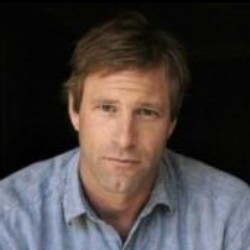

In [6]:
from PIL import Image, ImageFilter
path = "data/image/Aaron_Eckhart_0001.jpg"
im = Image.open(path)
im.show()

In [7]:
#!pip install scikit-image

In [8]:
!pip install scikit-image
import skimage


from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean

import os
path="data/lfw"
name=[]
image=[]
for x in os.listdir(path):
    if x=='.DS_Store':
        continue
    name.append(x)
    fileName=os.listdir(path+"/"+x+"/")[0]
    im=Image.open(path+"/"+x+"/"+fileName)
    
    #change to gray color
    grayIm=rgb2gray(im)
    #resize to 1/5, removing aliasing effect
    resizedIm=resize(grayIm, (grayIm.shape[0] // 5, grayIm.shape[1] // 5), anti_aliasing=True)
    #now image list contains all resized gray image
    image.append(resizedIm)

    
#image
#name
    

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 14.7 MB 133 kB/s eta 0:00:01
     |████████████████████████████████| 224 kB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 313 kB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 4.4 MB/s eta 0:00:01
  distutils: /home/hadoop/.local/lib/python3.9/site-packages
  sysconfig: /home/hadoop/.local/lib64/python3.9/site-packages
  user = True
  home = None
  root = None
  prefix = None


In [9]:
#[x[0] for x in image[0].reshape(2500,1).tolist()]

In [10]:
imageData=[]
for x in image:
    #each image needs to be flattened into one row in dataset
    imageData.append([y[0] for y in x.reshape(2500,1).tolist()])
#imageData[0:2]
#make it numpy array
imageDataNP=np.array(imageData)
imageDataNP.shape
    
    

(432, 2500)

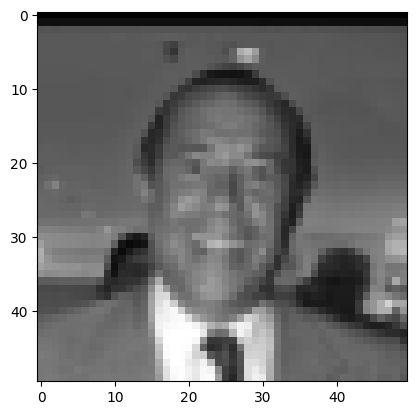

In [11]:
plt.imshow(imageDataNP[40].reshape(50,50), cmap="gray")

In [12]:
import pandas as pd
#load into Spark SQL Dataframe
df=spark.createDataFrame(pd.DataFrame(imageDataNP))

In [13]:
len(df.columns)

2500

In [14]:
labelCol=''

In [15]:
catcols=[]
for i in df.dtypes:
    if i[1] == 'string' and i[0] != labelCol:
        catcols.append(i[0])

In [16]:
num_cols=[]
for i in df.dtypes:
    if i[1] != 'string' and i[0] != labelCol:
        num_cols.append(i[0])

In [17]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# categorical columns
categorical_columns = catcols

In [18]:
indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categorical_columns ]

In [19]:
encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(), \
                           outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers ]

In [20]:
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() \
                                       for encoder in encoders] + num_cols, outputCol="features")

In [21]:
pipeline = Pipeline(stages=indexers + encoders + [assembler])
model=pipeline.fit(df)
data = model.transform(df)
#data = data.withColumn('label',col(labelCol))
df=data.select('features')
#df.show(5, truncate=False)

In [22]:
scaler = StandardScaler(inputCol="features",outputCol="scaledFeatures",withStd=True, withMean=True)
scalerModel=scaler.fit(df)

24/02/24 17:10:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/02/24 17:10:21 WARN TaskSetManager: Stage 0 contains a task of very large size (1194 KiB). The maximum recommended task size is 1000 KiB.


In [23]:
df=scalerModel.transform(df)

In [24]:
def findTopPrincipalComponentNumber(data:pyspark.sql.dataframe.DataFrame=df, \
                                    featureCol:str='features',threshold:int=0.80) -> (int, int):
    df_detect=data.select(featureCol)
    df_detect_list=[]
    for i in df_detect.collect():
        df_detect_list.append(i[0].tolist())
    df_detect_np=np.array(df_detect_list)
    cov_mat = np.cov(df_detect_np.T) #Get the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat) #Get list of Eigenvalues and list of Eigenvectors, 
                                                    #numbef of Eigenvalues = number of the feature columns 
    tot = sum(eigen_vals)
    var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)] #Sort the Eigenvalues in descending order
                                                                    #get the percentage of each Eigenvalue against 
                                                                    #sum of total eigenvalues
                                                                    #Then find number cumulative percentage from
                                                                    #first few largest eigenvalues to see threshold 
                                                                    #is crossed.  If so, you only need these few 
                                                                    #number of columns in PCA()
    cumulativePercept=0
    cumulativePerceptList=[]
    for i in var_exp:
        cumulativePercept+=i
        cumulativePerceptList.append(cumulativePercept)
        if cumulativePercept >= threshold:
            break
    return (len(cumulativePerceptList), float(cumulativePerceptList[-1]))

In [ ]:
bestK, coverPercentage=findTopPrincipalComponentNumber(data=df, featureCol='scaledFeatures', threshold=0.80)
print(f"{bestK} principal components covers the {round(coverPercentage*100,2)}% from original dataset")

In [ ]:
df.show(2)

In [ ]:
from pyspark import SparkContext
# $example on$
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

In [ ]:
sc=spark.sparkContext

In [ ]:
#Convert from Spark SQL Dataframe to RDD
rows=df.select("scaledFeatures").rdd.map(lambda r: [Vectors.dense(r[:])])

In [ ]:
#Make RowMatrix, which is required to run PCA
mat = RowMatrix(rows)

In [ ]:
#Execute PCA, this PCA can produce Eigenface, which is pcaRDD here
pcaRDD=mat.computePrincipalComponents(bestK)

In [ ]:
pcaRDD.numCols


In [ ]:
pcaRDD.numRows

In [ ]:
pcs=pcaRDD.toArray()
pcs.shape

In [ ]:
def plot_gallery(images, h, w, n_row=4, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[:, i].reshape((h, w)),cmap=plt.cm.gray)


In [ ]:
#Since there are 16 principle components, hence there are 16 Eigenface to plot
#Each of these 16 Eigenfaces carries the top 16 more prominent features of this person
plot_gallery(pcs, 50, 50)

In [ ]:
imageDataNP[0].reshape(50,50)

In [ ]:
projected=mat.multiply(pcaRDD)

In [ ]:
projected.numCols()

In [ ]:
projected.numRows()